In [1]:
import numpy as np
import os 
import time
import pickle

import colour

# My custom library of photoelastic tools
import sys
sys.path.append('/eno/jdfeathe/pepe/')
#sys.path.append('/home/jack//workspaces/jupyter-workspace/pepe/')

from pepe.visualize import visCircles, visForces
from pepe.analysis import testForceBalance, polarToCartesian

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 140
plt.rcParams["font.size"] = 13

In [14]:
syntheticFolder = '../'
dataSet = '2022-04-15_100_MMM_Gap0_2_Synthetic_0/'

pIndex = 1

In [15]:
with open(syntheticFolder + dataSet + 'forces.pickle', 'rb') as f:
    forceArr = pickle.load(f)
with open(syntheticFolder + dataSet + 'betas.pickle', 'rb') as f:
    betaArr = pickle.load(f)
with open(syntheticFolder + dataSet + 'alphas.pickle', 'rb') as f:
    alphaArr = pickle.load(f)
with open(syntheticFolder + dataSet + 'centers.pickle', 'rb') as f:
    centerArr = pickle.load(f)
with open(syntheticFolder + dataSet + 'radii.pickle', 'rb') as f:
    radiusArr = pickle.load(f)
with open(syntheticFolder + dataSet + 'angles.pickle', 'rb') as f:
    angleArr = pickle.load(f)

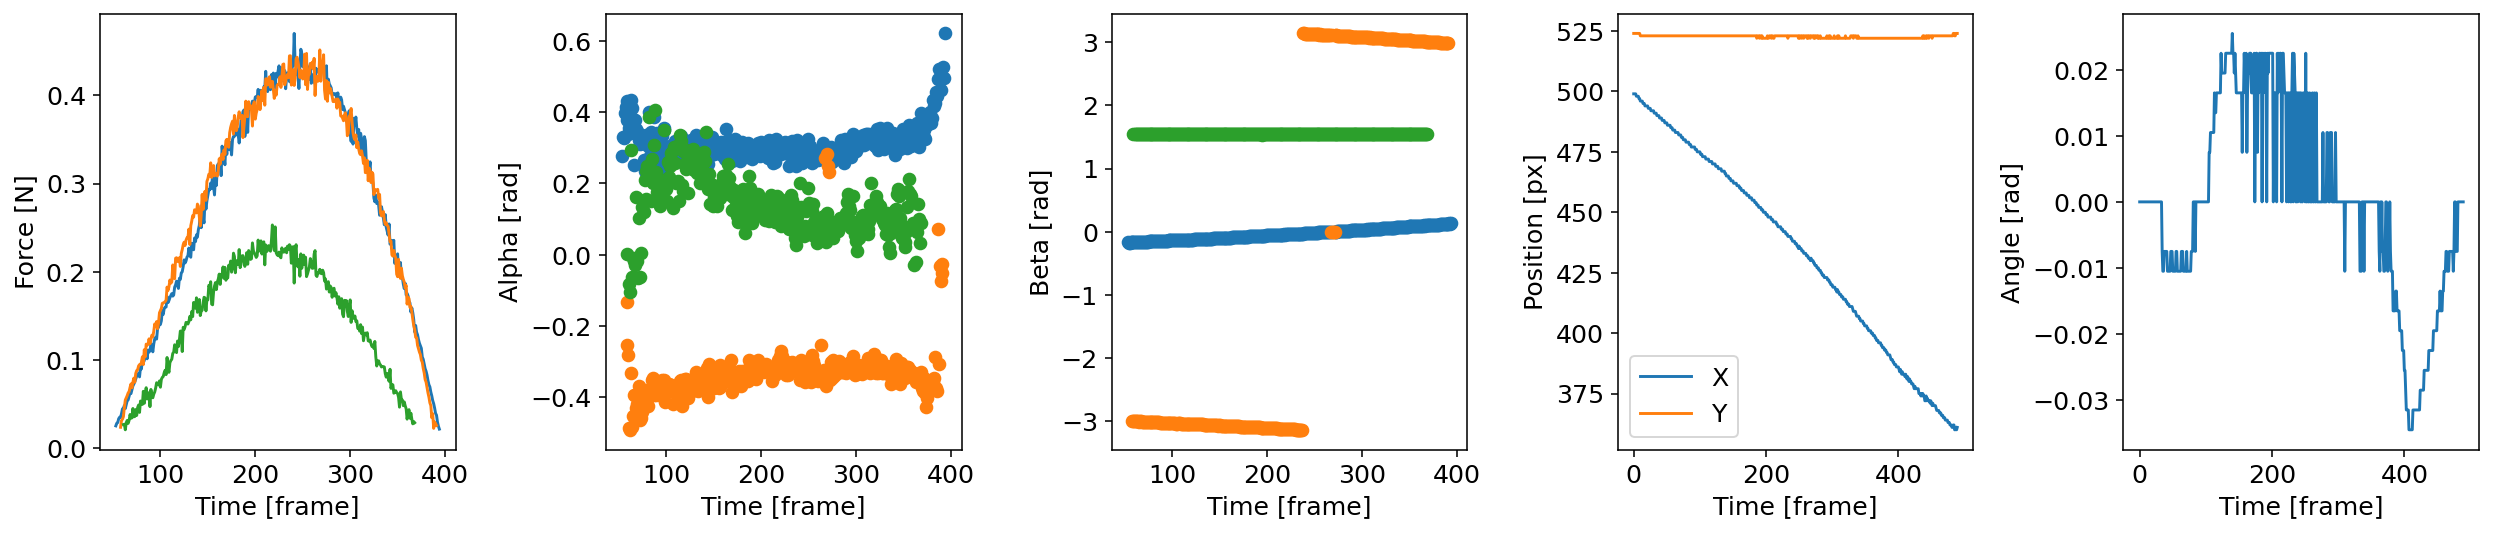

In [16]:
fig, ax = visForces(forceArr[pIndex], alphaArr[pIndex], betaArr[pIndex], centerArr[pIndex], angleArr[pIndex])
#fig.tight_layout()
plt.show()

In [17]:
xyForceArr = np.zeros((*forceArr[pIndex].shape, 2))
for i in range(xyForceArr.shape[1]):
    xyForceArr[:,i] = polarToCartesian(forceArr[pIndex][:,i], alphaArr[pIndex][:,i], betaArr[pIndex][:,i])
    #xyForceArr[:,i] = polarToCartesianForces(forceArr[pIndex], np.zeros_like(alphaArr[pIndex]), betaArr[pIndex])

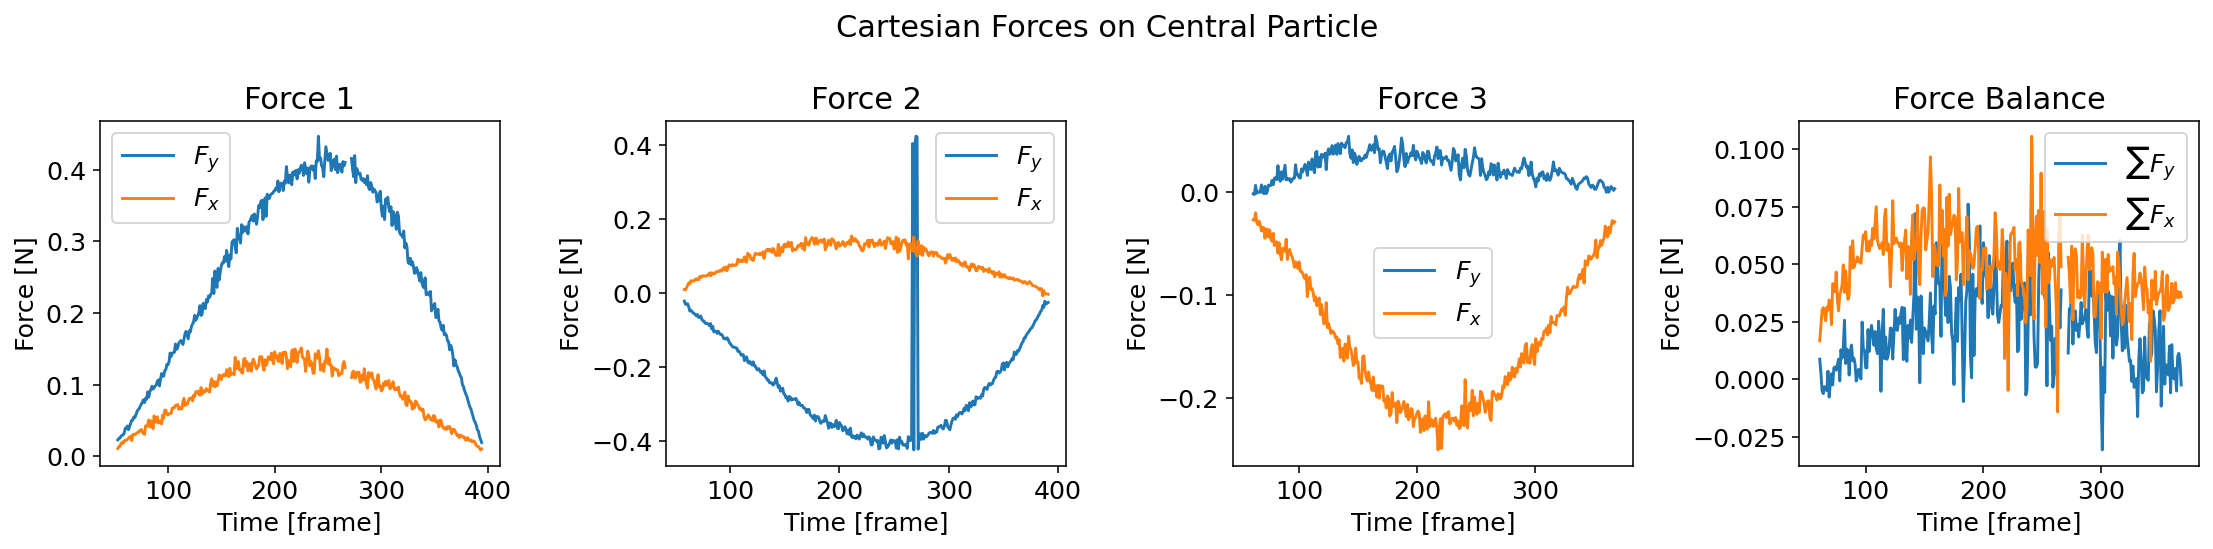

In [21]:
fig, ax = plt.subplots(1, len(forceArr[pIndex])+1, figsize=(16,4))

for i in range(len(forceArr[pIndex])):
    ax[i].plot(xyForceArr[i,:,0], label=r'$F_y$')
    ax[i].plot(xyForceArr[i,:,1], label=r'$F_x$')
    ax[i].legend()

# Sum up all x forces
xForceSumArr = np.sum(xyForceArr[:,:,1], axis=0)
yForceSumArr = np.sum(xyForceArr[:,:,0], axis=0)

ax[-1].plot(yForceSumArr, label=r'$\sum F_y$')
ax[-1].plot(xForceSumArr, label=r'$\sum F_x$')
ax[-1].legend()

for i in range(len(ax)):
    ax[i].set_title(f'Force {i+1}')
    ax[i].set_xlabel('Time [frame]')
    ax[i].set_ylabel('Force [N]')

ax[-1].set_title('Force Balance')
fig.suptitle('Cartesian Forces on Central Particle')
fig.tight_layout()
plt.savefig('../images/cartesian_force_with_alpha.png')
plt.show()

## Compare multiple trials



In [41]:
syntheticFolder = '../'
dataKey = '2022-03-29_Medium_Synthetic_1to'

fileList = os.listdir(syntheticFolder)

fileList = [f for f in fileList if dataKey in f]
#fileList = fileList[:3]
fileList = fileList[:-2]

weightingRatios = [1/float(f.split('_')[3].split('to')[-1]) for f in fileList]

order = np.argsort(weightingRatios)
fileList = np.array(fileList)[order]
weightingRatios = np.array(weightingRatios)[order]
pIndex = 3

for i in range(len(fileList)):
    print(f'{fileList[i]:.45}: {weightingRatios[i]:.3}')

2022-03-29_Medium_Synthetic_1toInf_FBW_0: 0.0
2022-03-29_Medium_Synthetic_1to20_FBW: 0.05
2022-03-29_Medium_Synthetic_1to16_FBW: 0.0625
2022-03-29_Medium_Synthetic_1to12_FBW: 0.0833
2022-03-29_Medium_Synthetic_1to8_FBW: 0.125
2022-03-29_Medium_Synthetic_1to4_FBW: 0.25
2022-03-29_Medium_Synthetic_1to3_FBW: 0.333
2022-03-29_Medium_Synthetic_1to2_FBW: 0.5


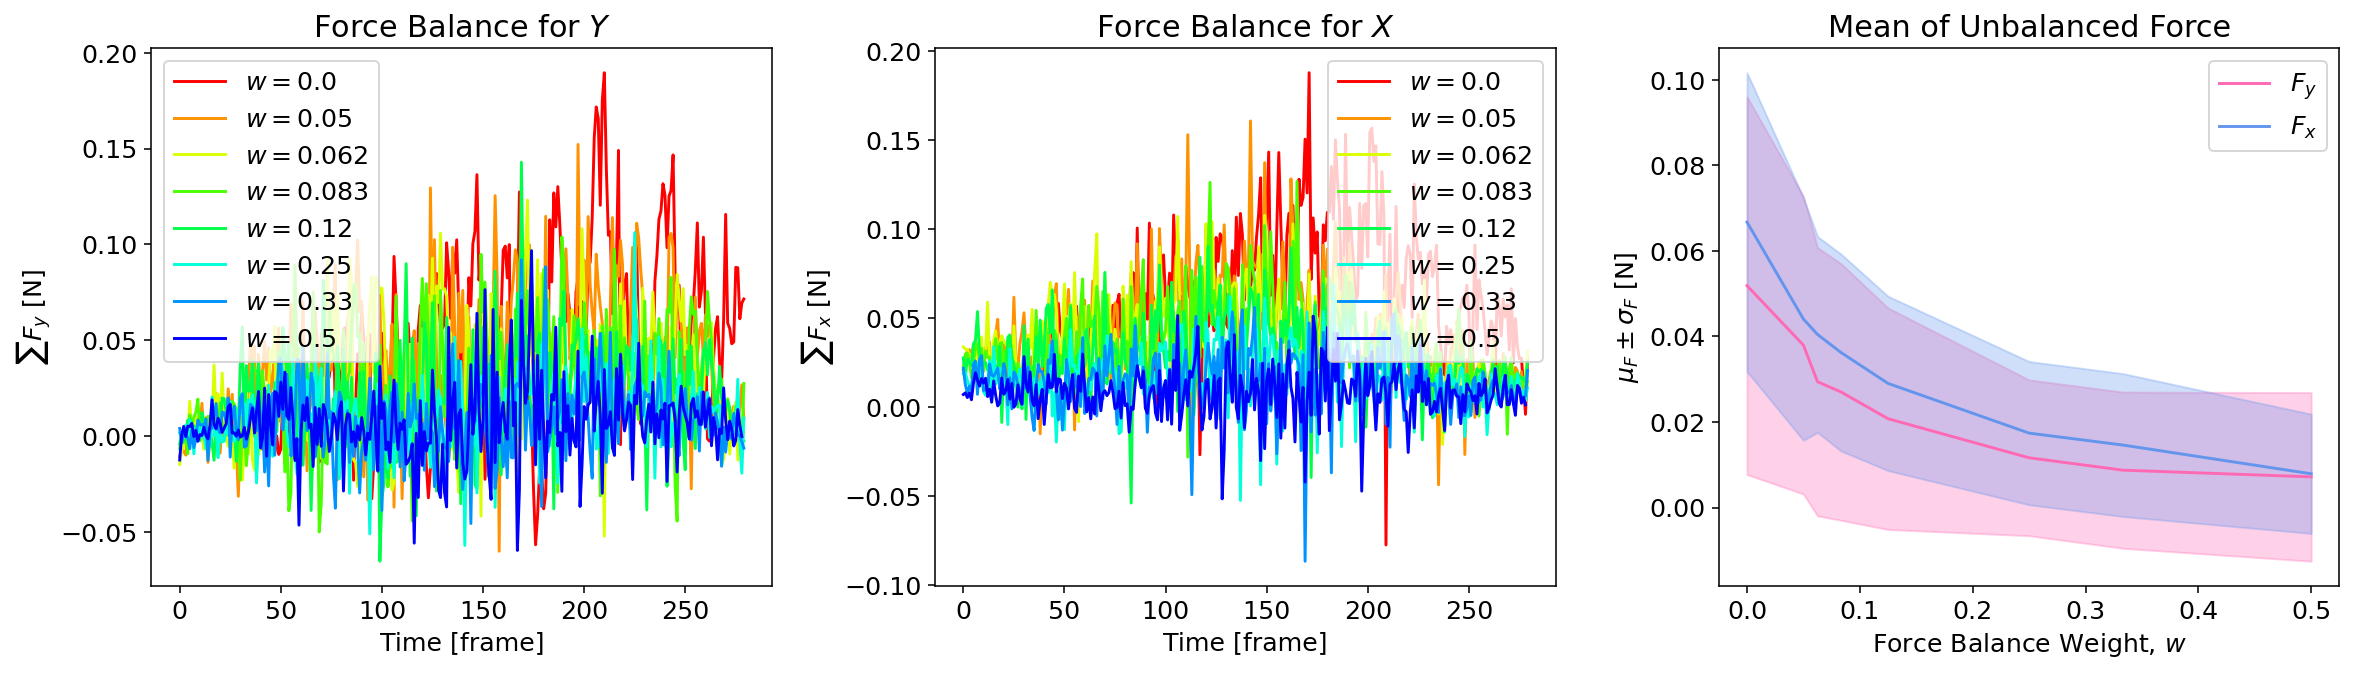

In [60]:
colors = list(colour.Color('Red').range_to(colour.Color('Blue'), len(fileList)))
colors = [str(c) for c in colors]

meanArr = np.zeros((len(fileList), 2))
stdArr = np.zeros((len(fileList), 2))

fig, ax = plt.subplots(1, 3, figsize=(17,5))

for i in range(len(fileList)):
    
    with open(syntheticFolder + fileList[i] + '/forces.pickle', 'rb') as f:
        forceArr = pickle.load(f)
    with open(syntheticFolder + fileList[i] + '/betas.pickle', 'rb') as f:
        betaArr = pickle.load(f)
    with open(syntheticFolder + fileList[i] + '/alphas.pickle', 'rb') as f:
        alphaArr = pickle.load(f)
    with open(syntheticFolder + fileList[i] + '/centers.pickle', 'rb') as f:
        centerArr = pickle.load(f)
    with open(syntheticFolder + fileList[i] + '/radii.pickle', 'rb') as f:
        radiusArr = pickle.load(f)
    with open(syntheticFolder + fileList[i] + '/angles.pickle', 'rb') as f:
        angleArr = pickle.load(f)
    
    forceBalanceArr = testForceBalance(forceArr[pIndex][:,:280], alphaArr[pIndex][:,:280], betaArr[pIndex][:,:280])
    
    for j in range(2):
        meanArr[i,j] = np.nanmean(forceBalanceArr[:,j])
        stdArr[i,j] = np.nanstd(forceBalanceArr[:,j])

    ax[0].plot(forceBalanceArr[:,0], label=f'$w={weightingRatios[i]:.2}$', c=colors[i])
    ax[1].plot(forceBalanceArr[:,1], label=f'$w={weightingRatios[i]:.2}$', c=colors[i])


ax[2].plot(weightingRatios, meanArr[:,0], label=r'$F_y$', c=str(colour.Color('hotpink')))
ax[2].fill_between(weightingRatios, meanArr[:,0] + stdArr[:,0], meanArr[:,0] - stdArr[:,0], alpha=.3, color=str(colour.Color('hotpink')))
ax[2].plot(weightingRatios, meanArr[:,1], label=r'$F_x$', c=str(colour.Color('cornflowerblue')))
ax[2].fill_between(weightingRatios, meanArr[:,1] + stdArr[:,1], meanArr[:,1] - stdArr[:,1], alpha=.3, color=str(colour.Color('cornflowerblue')))

ax[0].legend()
ax[0].set_xlabel('Time [frame]')
ax[0].set_ylabel(r'$\sum F_y$ [N]')
ax[0].set_title('Force Balance for $Y$')

ax[1].legend()
ax[1].set_xlabel('Time [frame]')
ax[1].set_ylabel(r'$\sum F_x$ [N]')
ax[1].set_title('Force Balance for $X$')

ax[2].legend()
ax[2].set_xlabel('Force Balance Weight, $w$')
ax[2].set_ylabel(r'$\mu_F \pm \sigma_F$ [N]')
ax[2].set_title('Mean of Unbalanced Force')

fig.tight_layout()
plt.savefig('../images/force_balance_weighting.png')
plt.show()